# Vignnette

This vignette serves as brief tutorial on the basic functionality of the implementation of a discrete time, discrete space Hidden Markov Model used for Latent Trajectory Analysis in the paper. This includes the tools for simulation, estimation, and visualisation

In [1]:
using PlotlyJS

# display functionalities
function to_pngbytes(fig; scale=2, width=nothing, height=nothing)
    io = IOBuffer()
    # Build keyword args for size/scale without writing to disk
    opts = Dict{Symbol,Any}(:format => "png", :scale => scale)
    width  === nothing || (opts[:width]  = width)
    height === nothing || (opts[:height] = height)
    savefig(io, fig; opts...)     # write PNG to buffer
    seekstart(io)
    return take!(io)              # raw PNG bytes
end
show_png(bytes) = display("image/png", bytes)

show_png (generic function with 1 method)

## Simulation

Let's specify a simulation of a $3$ state, fully connected HMM which outputs 4 binary observations, 2 continuous observation. We make sure that initial state probabilities are parameterised by a multinomial function using covariates $x_3$ and $x_5$, while transition probabilities use $x_8$.

In [2]:
include("../src/LTA.jl")
using .LTA

sim_hyper = LTA.SimHyperParams(
    param_seed = 1,

	N = 5000,

	n_obs_tup = (
		bernoulli = 4,
		gaussian = 2
	),
	n_states = 3,
	ref_state = 1,
	covariate_tup = (
		initial = ["x3", "x5"], 
		trans = ["x8"], 
		em = []), 
	sim_no = "",
	comments = ""
)
sim_params = LTA.gen_params_from_hyper_params(sim_hyper)
keys(sim_params.model_params)

(:beta_initial, :beta_transition, :rho_initial, :rho_trans, :emissions)

Taking a look at the paramters which were randomly generated, we see the three most important components:
- the $\beta$ coefficients which generate the initial state probability vector, 
- the $\beta$ coefficients which generate the transition probabilities between states
- components which construct the paramters used for emission (e.g means $\mu$ used for the Guassian distribution)

Let's simulate 5 timepoints now:

In [3]:
sim_output = LTA.run_simulation(
	sim_params;
	T = 5
	)

Main.LTA.SimulationOutput(Main.LTA.SimParams(Main.LTA.SimHyperParams(1, 5000, (bernoulli = 4, gaussian = 2), 3, (initial = ["x3", "x5"], trans = ["x8"], em = Any[]), 1, "", ""), ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19", "x20"], [1.0 0.0 … 1.0 1.0; 1.0 0.0 … 0.0 1.0; … ; 1.0 0.0 … 0.0 1.0; 1.0 0.0 … 1.0 0.0], (beta_initial = [0.0 0.0; 1.4977475724484632 0.5009564773194146; 1.6962803477126407 0.9490147857291875], beta_transition = [0.0 0.0; 1.1080366793357879 1.3534306129330096; -0.7947585858236712 0.0962348753912936;;; 0.0 0.0; 1.7260616566505886 0.045930602097062234; -1.8230879061936962 1.2118439932583556;;; 0.0 0.0; -1.6572934310701033 -0.39561650164893347; -0.5501469182786991 0.02978154473800121], rho_initial = [-0.5328143502403027, 0.09551429913764675], rho_trans = [1.2467936199834462], emissions = (beta_bernoulli = [-1.950569182261888; 1.5771468899828776; 1.5234034615163772;;; 1.0770107622661707; 1.4

## Estimation

We can now estimate the parameters. Here we specify 2 multistarts, where each run is optimised using a BFGS scheme, using a $\lambda = 10$ penalty (soft constraint for the $\rho$'s). The object returned contains a list of the optimisation details.

In [4]:
est_output = LTA.run_estimation(
    sim_output;
    est_seed = 2,
    meth = "BFGS",
    n_starts = 2,
    lambda = 10.0,
	calculate_hessian = false,

    # kwargs for the optimisation run from Optim can be passed here
    iterations = 100
)


Estimating
Iter     Function value   Gradient norm 
Iter     Function value   Gradient norm 
     0     1.062136e+05     6.991434e+04
     0     1.199245e+05     5.377148e+04
 * time: 0.02350902557373047
 * time: 0.021963119506835938
     1     7.056673e+04     2.254840e+04
 * time: 6.280602931976318
     1     8.610822e+04     1.983733e+04
 * time: 6.389255046844482
     2     5.966462e+04     1.511013e+04
 * time: 10.369977951049805
     2     7.236862e+04     1.621264e+04
 * time: 11.471943855285645
     3     4.824756e+04     1.561940e+04
 * time: 14.203408002853394
     3     6.508157e+04     1.785520e+04
 * time: 15.472254991531372
     4     4.265628e+04     1.160717e+04
 * time: 18.10944390296936
     4     5.260828e+04     2.887849e+04
 * time: 19.33032202720642
     5     4.045058e+04     9.273789e+03
 * time: 21.29736590385437
     5     4.151189e+04     1.028977e+04
 * time: 24.619750022888184
     6     3.589019e+04     9.659170e+03
 * time: 25.871052980422974
     6     

Main.LTA.EstimationOutput(Main.LTA.SimulationOutput(Main.LTA.SimParams(Main.LTA.SimHyperParams(1, 5000, (bernoulli = 4, gaussian = 2), 3, (initial = ["x3", "x5"], trans = ["x8"], em = Any[]), 1, "", ""), ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19", "x20"], [1.0 0.0 … 1.0 1.0; 1.0 0.0 … 0.0 1.0; … ; 1.0 0.0 … 0.0 1.0; 1.0 0.0 … 1.0 0.0], (beta_initial = [0.0 0.0; 1.4977475724484632 0.5009564773194146; 1.6962803477126407 0.9490147857291875], beta_transition = [0.0 0.0; 1.1080366793357879 1.3534306129330096; -0.7947585858236712 0.0962348753912936;;; 0.0 0.0; 1.7260616566505886 0.045930602097062234; -1.8230879061936962 1.2118439932583556;;; 0.0 0.0; -1.6572934310701033 -0.39561650164893347; -0.5501469182786991 0.02978154473800121], rho_initial = [-0.5328143502403027, 0.09551429913764675], rho_trans = [1.2467936199834462], emissions = (beta_bernoulli = [-1.950569182261888; 1.5771468899828776; 1.5234034615163772;

## Results

After completing the estimation, the est_output object can give details related to the optimisation run. What is of most interest is usually are the converged parameters, est_output.fitted_model_params

In [5]:
est_output.sim_output.sim_params.model_params

(beta_initial = [0.0 0.0; 1.4977475724484632 0.5009564773194146; 1.6962803477126407 0.9490147857291875], beta_transition = [0.0 0.0; 1.1080366793357879 1.3534306129330096; -0.7947585858236712 0.0962348753912936;;; 0.0 0.0; 1.7260616566505886 0.045930602097062234; -1.8230879061936962 1.2118439932583556;;; 0.0 0.0; -1.6572934310701033 -0.39561650164893347; -0.5501469182786991 0.02978154473800121], rho_initial = [-0.5328143502403027, 0.09551429913764675], rho_trans = [1.2467936199834462], emissions = (beta_bernoulli = [-1.950569182261888; 1.5771468899828776; 1.5234034615163772;;; 1.0770107622661707; 1.4171734221829242; -0.6565746628981595;;; 0.06935046601853934; -1.8177658869321194; 0.4499403910700597;;; -0.30569545122641095; -1.0422092494352828; -0.16632145809138965], beta_gaussian = (means = [0.7882858427169706 -1.1133024566073306; 0.3763251907944162 0.19644684878641908; -0.024929178133683456 -0.5978663145750528], stds = [-2.9834503022620362 -2.4251750248429174; -2.35688990561417 -2.378

## Plotting

Using the plotting tools, you can quickly inspect the various parameters in est_output.fitted_model_params and how different optimisation run result in different models

### Initial State Distributions

┌ Warning: attempting to remove probably stale pidfile
│   path = /home/rgus/.jlassetregistry.lock
└ @ Pidfile /home/rgus/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


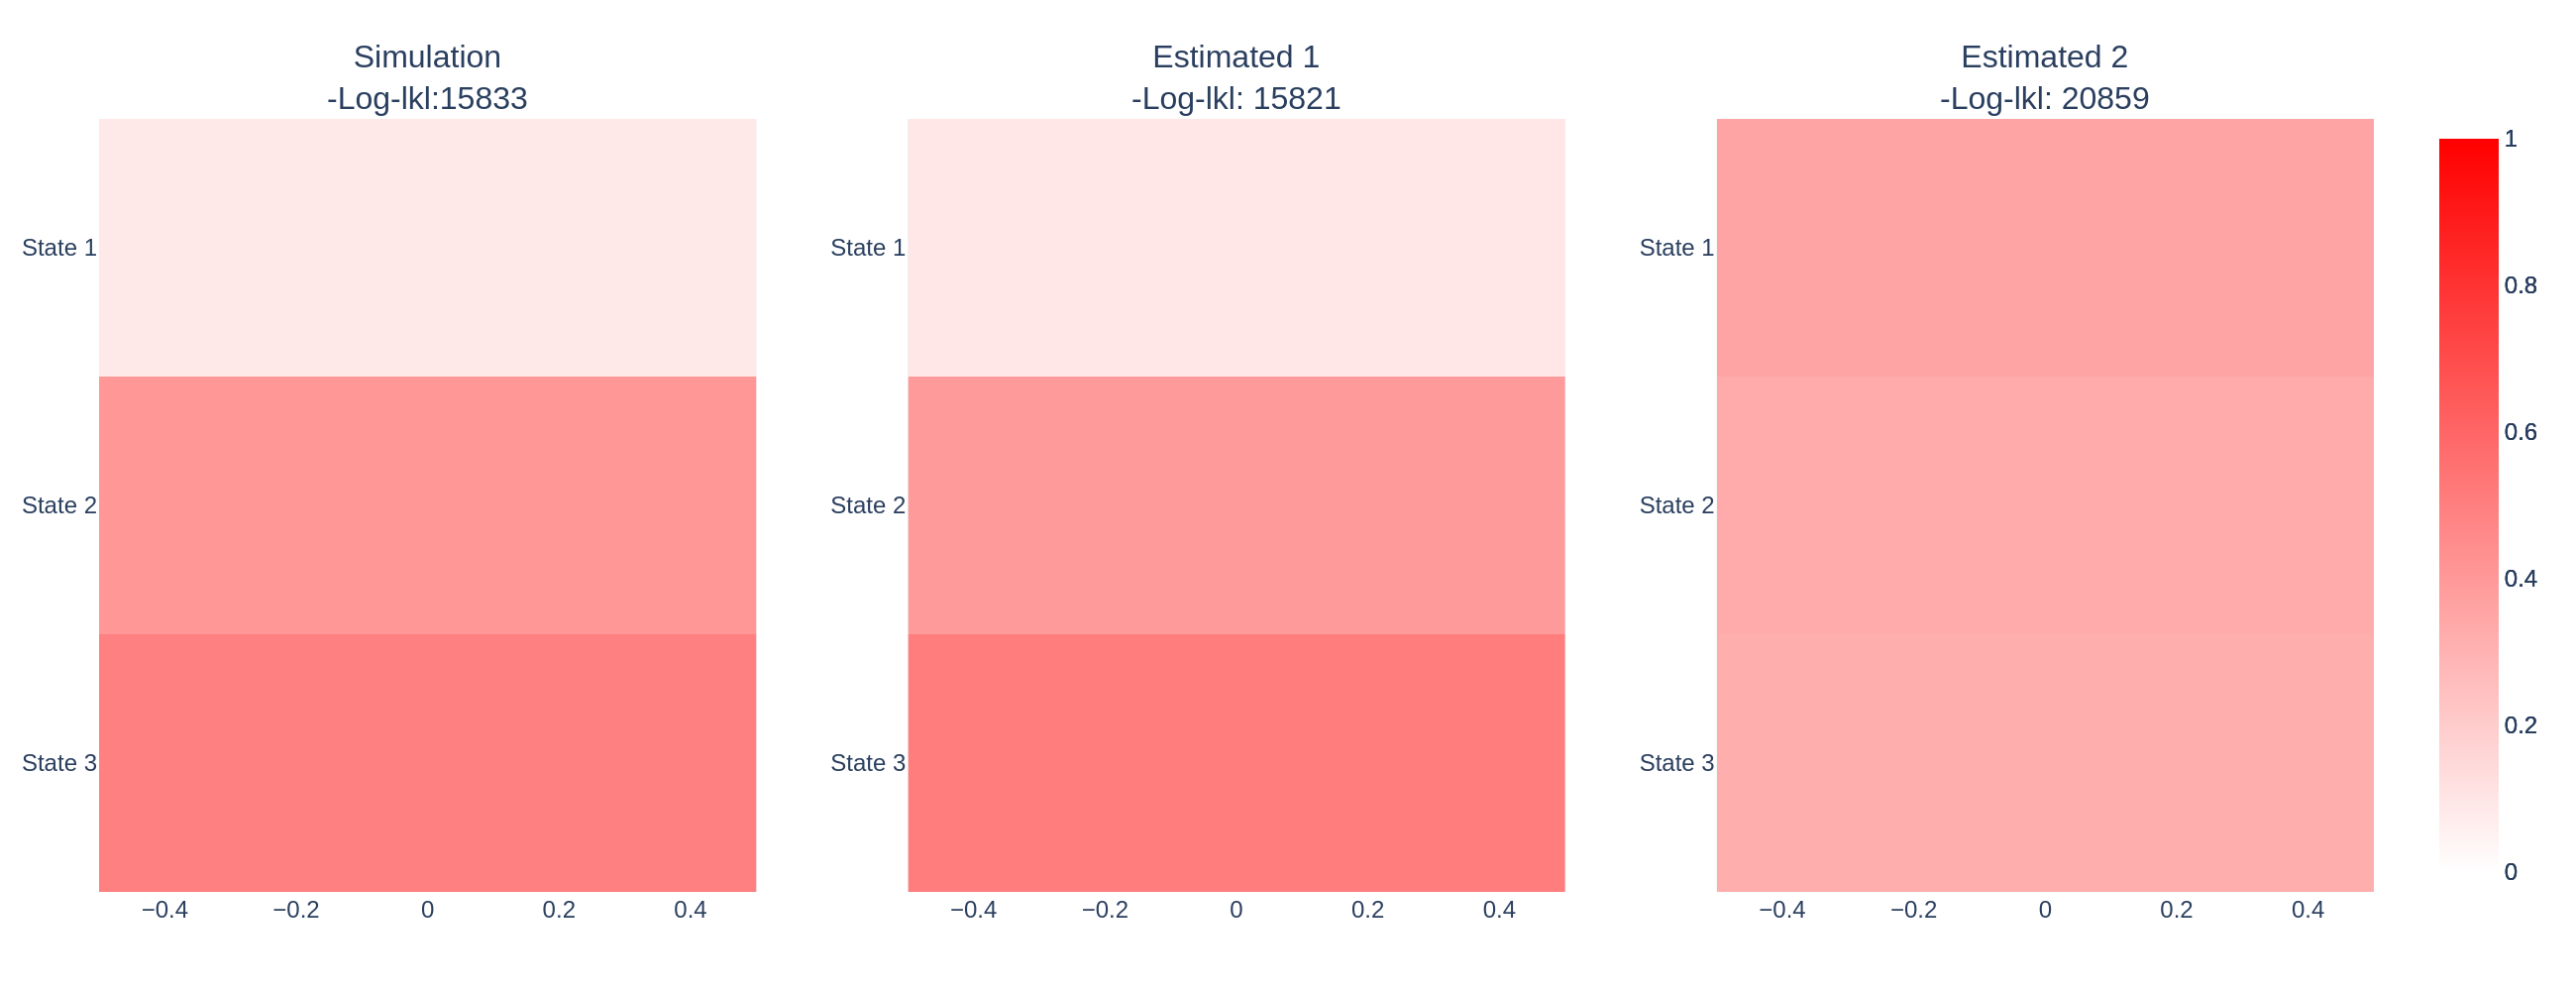

In [6]:
initial_probability_heatmaps = LTA.compare_initial_heatmaps(est_output)
show_png(to_pngbytes(initial_probability_heatmaps; width = 1300))

### Bernoulli Emissions

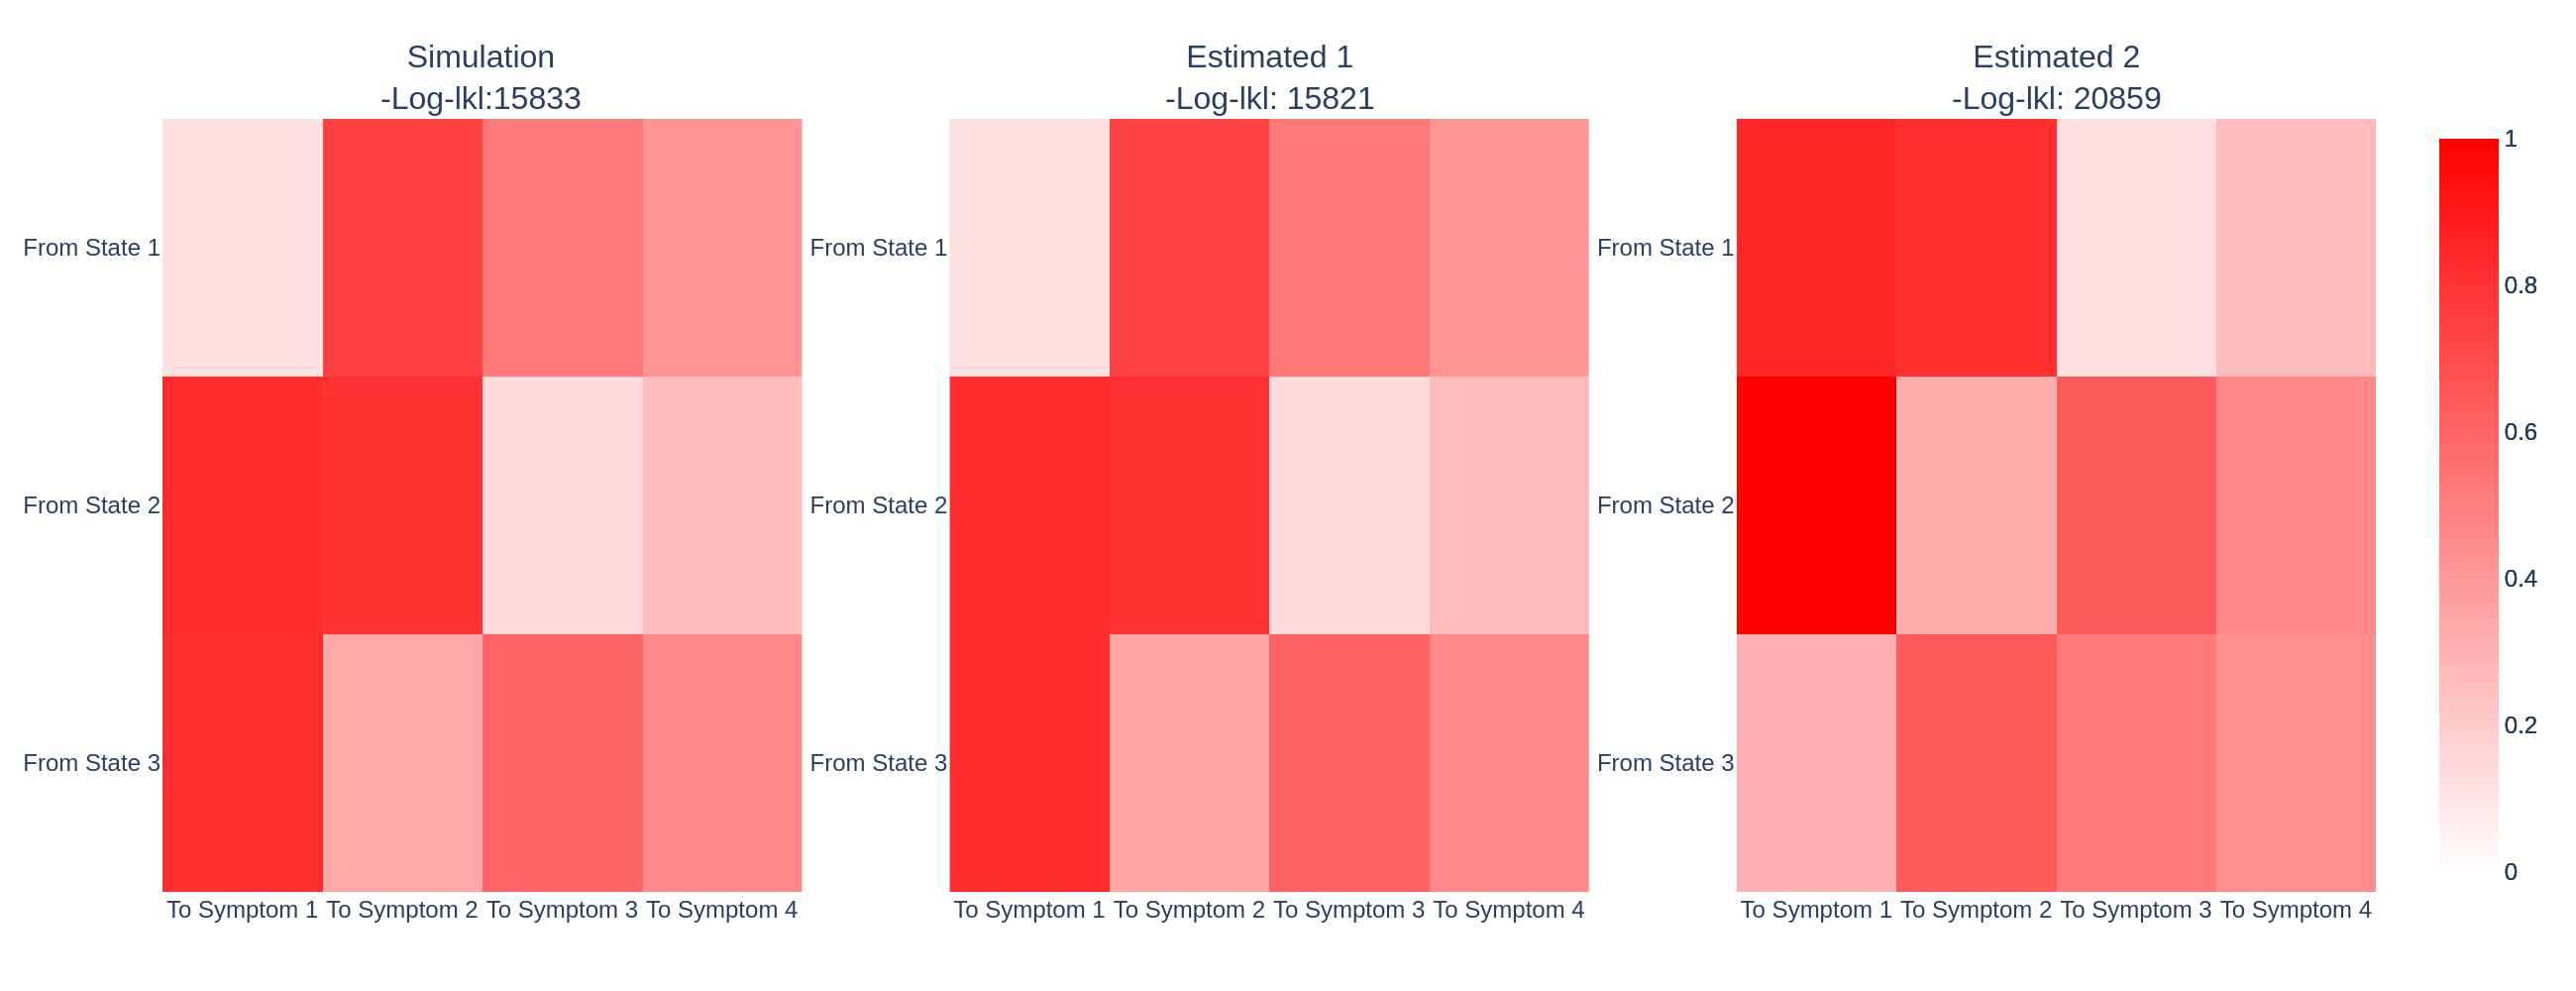

In [7]:
bernoulli_heatmaps = LTA.compare_bernoulli_heatmaps(est_output)
show_png(to_pngbytes(bernoulli_heatmaps; width = 1300))

### Gaussian Emissions

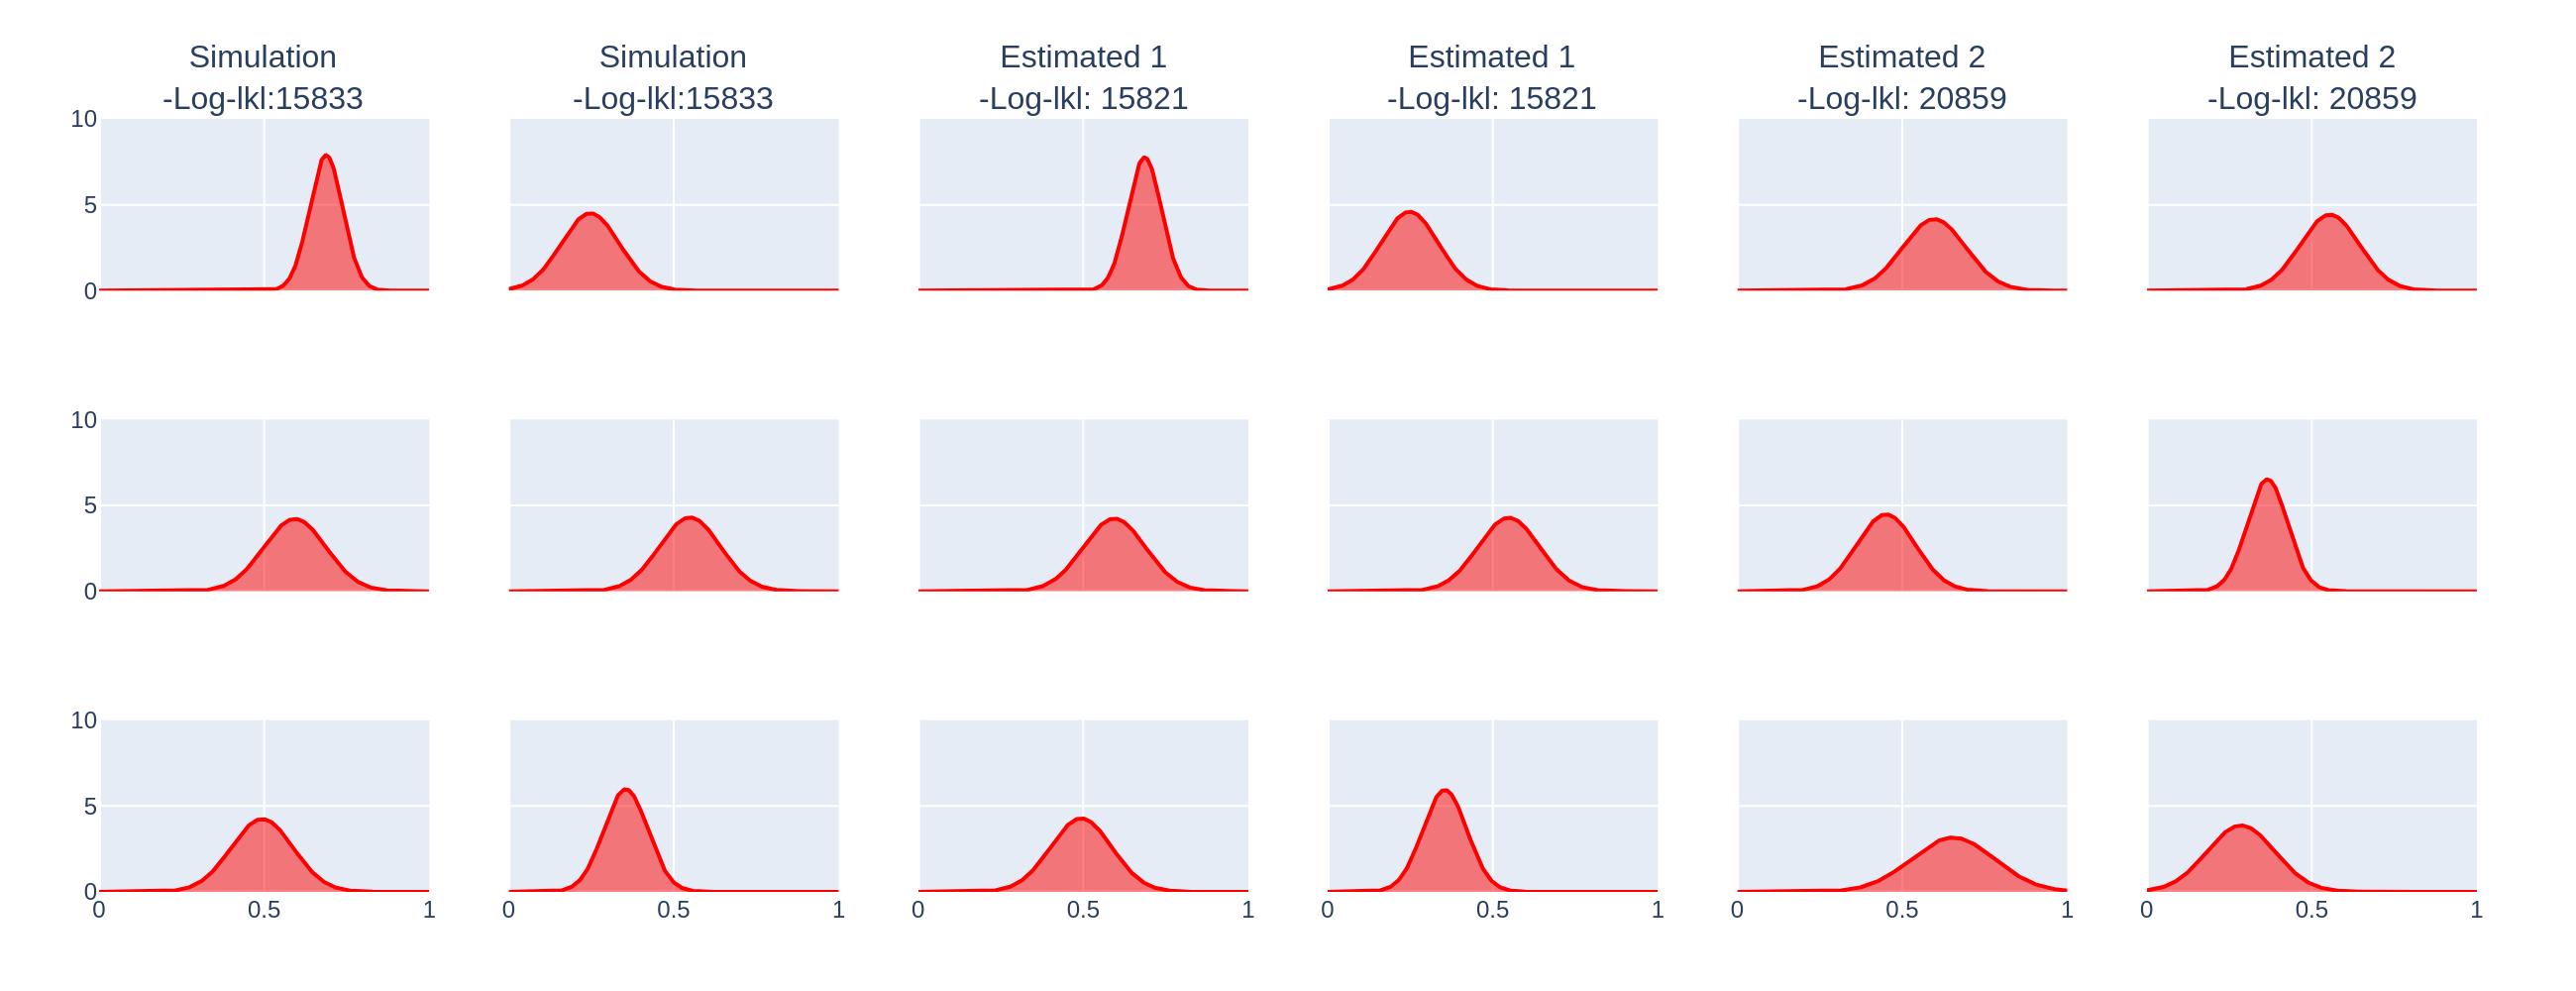

In [8]:
gaussian_pdf = LTA.compare_gaussian_pdf(est_output)
show_png(to_pngbytes(gaussian_pdf; width = 1300)) 

### Transition Probabilities

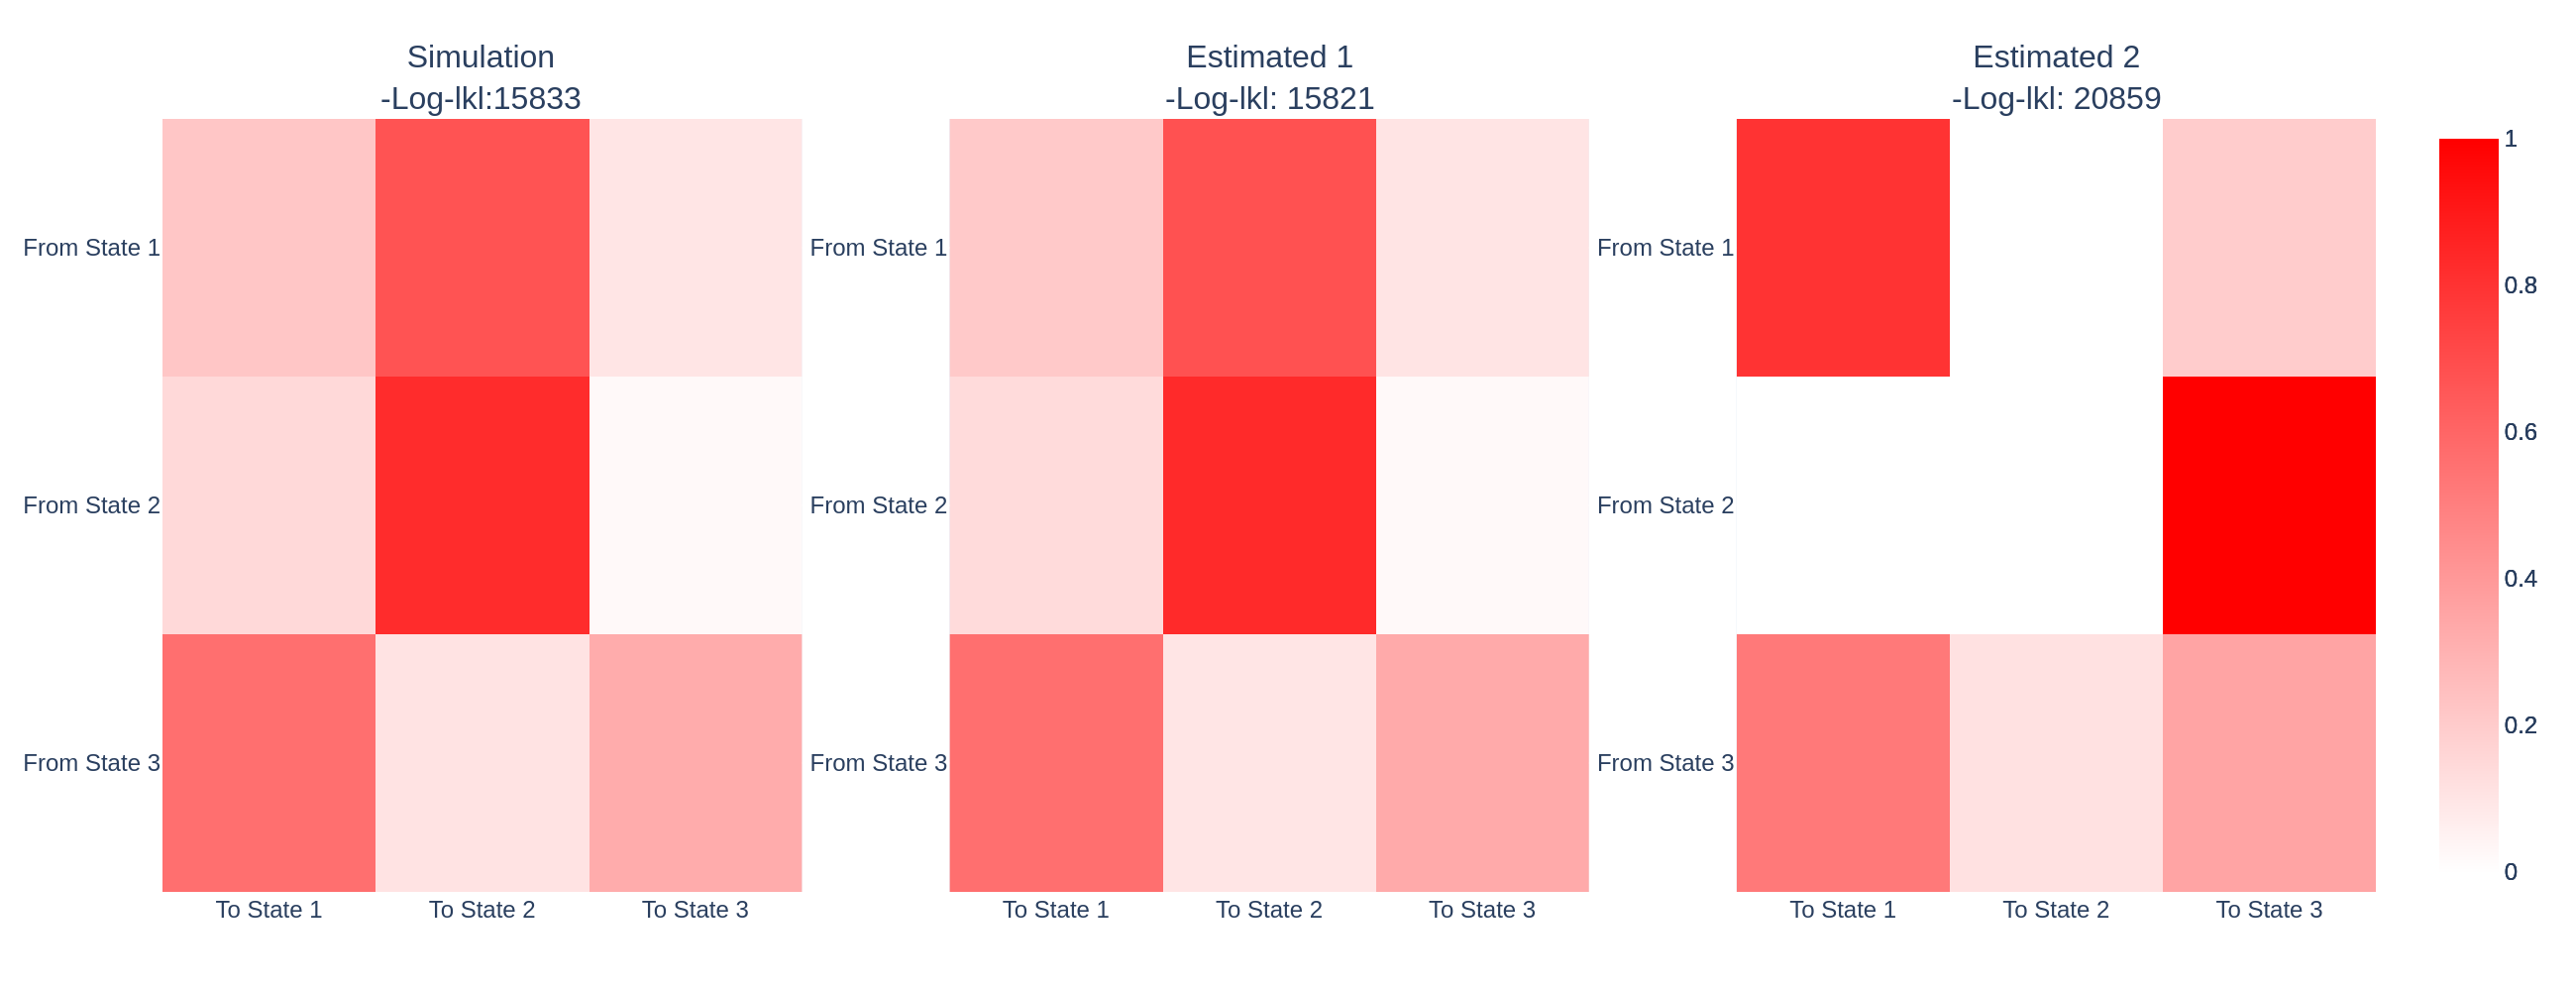

In [9]:
transition_probability_heatmaps = LTA.compare_trans_heatmaps(est_output)
show_png(to_pngbytes(transition_probability_heatmaps; width = 1300))

### Covariate Impact

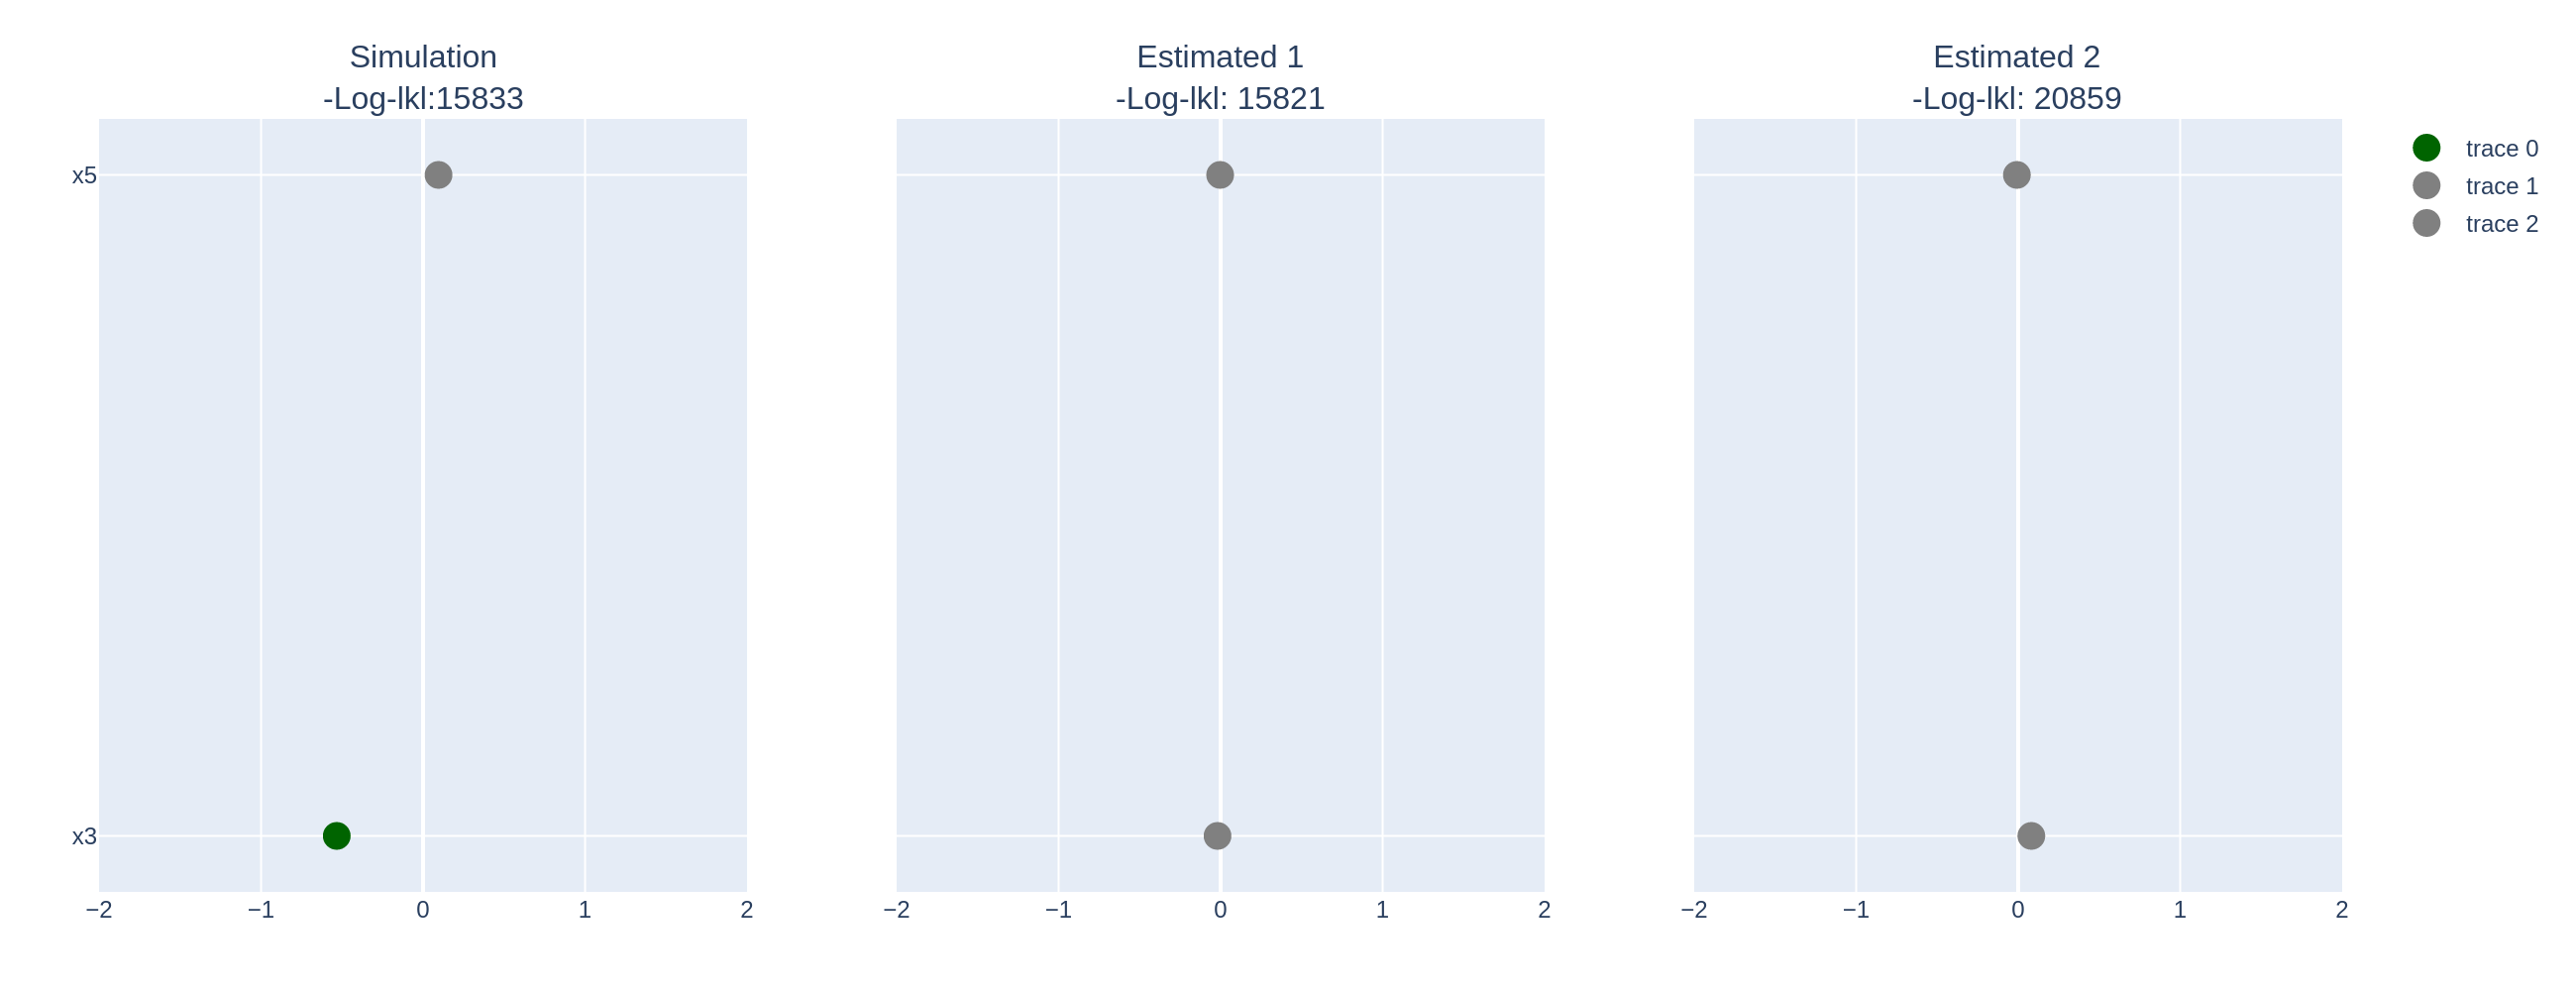

In [10]:
rho_scatter = LTA.compare_rhos(est_output)
show_png(to_pngbytes(rho_scatter; width = 1300)) 

We see that the first estimation was succesfully able to recover the correct model parameters! Note that the second solution is poor, however it still is able to roughly capture the correct emissions matrix (swapping States 1 -> 2, 2 -> 3, 3 -> 1) even if it doesn't appear so at first glance.

## Evaluations

Let's see now how our predicted symptom occurences line up against the dataset we trained on.

For the Bernoulli distributed symptoms, we compare the percentage frequency over time:

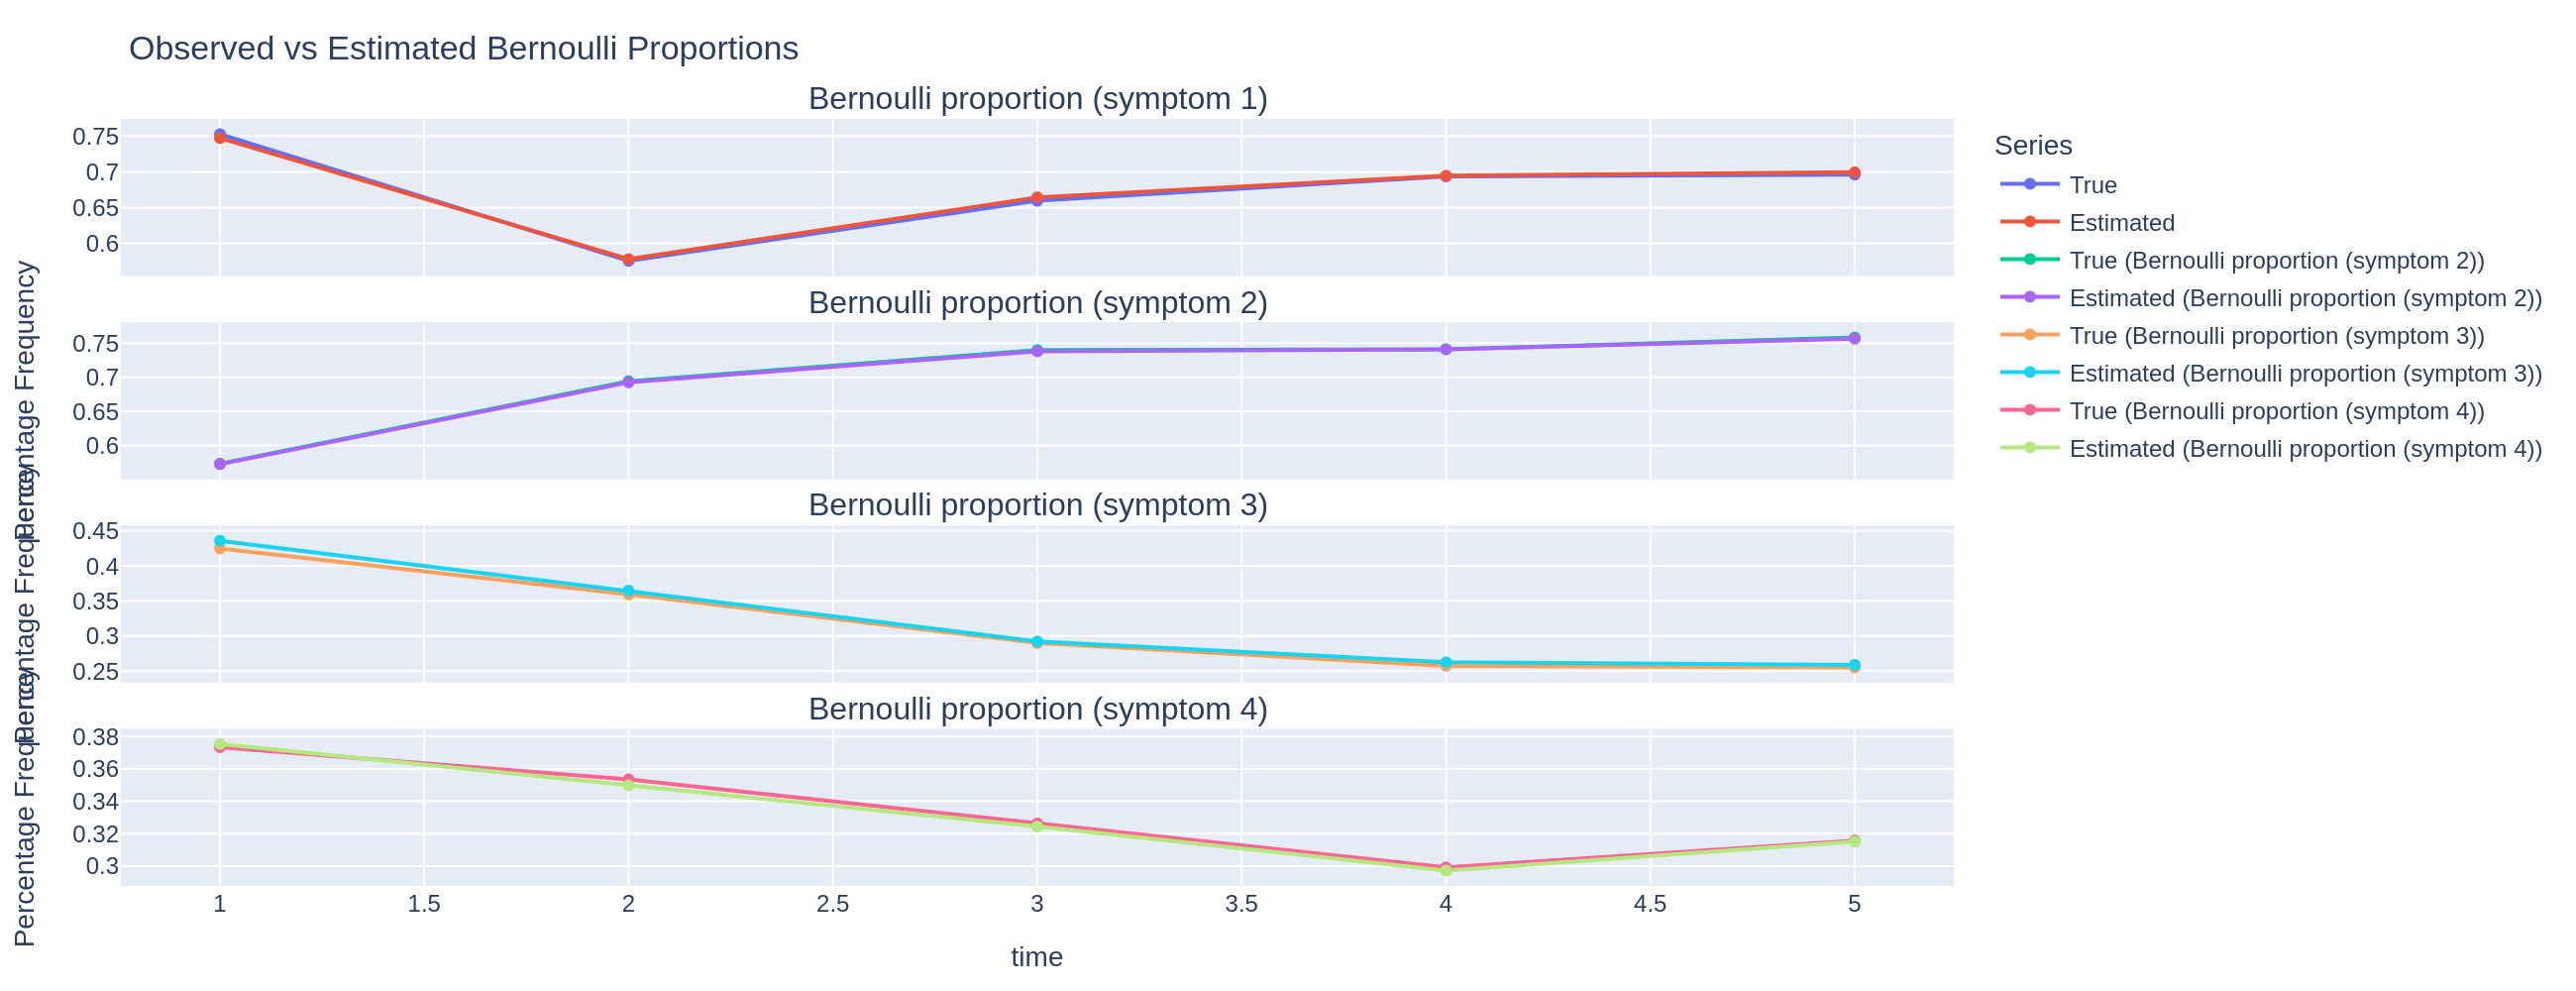

In [11]:
bernoulli_predictions = LTA.compare_estimation_2_data(
    est_output;
    simulation_seed = 1,
    T = 5,
    type = "best_fitted",
    observation_type = "bernoulli",
)
show_png(to_pngbytes(bernoulli_predictions; width = 1300)) 

While for Gausssian observations, let's inspect the expected means and actual means of the dataset:

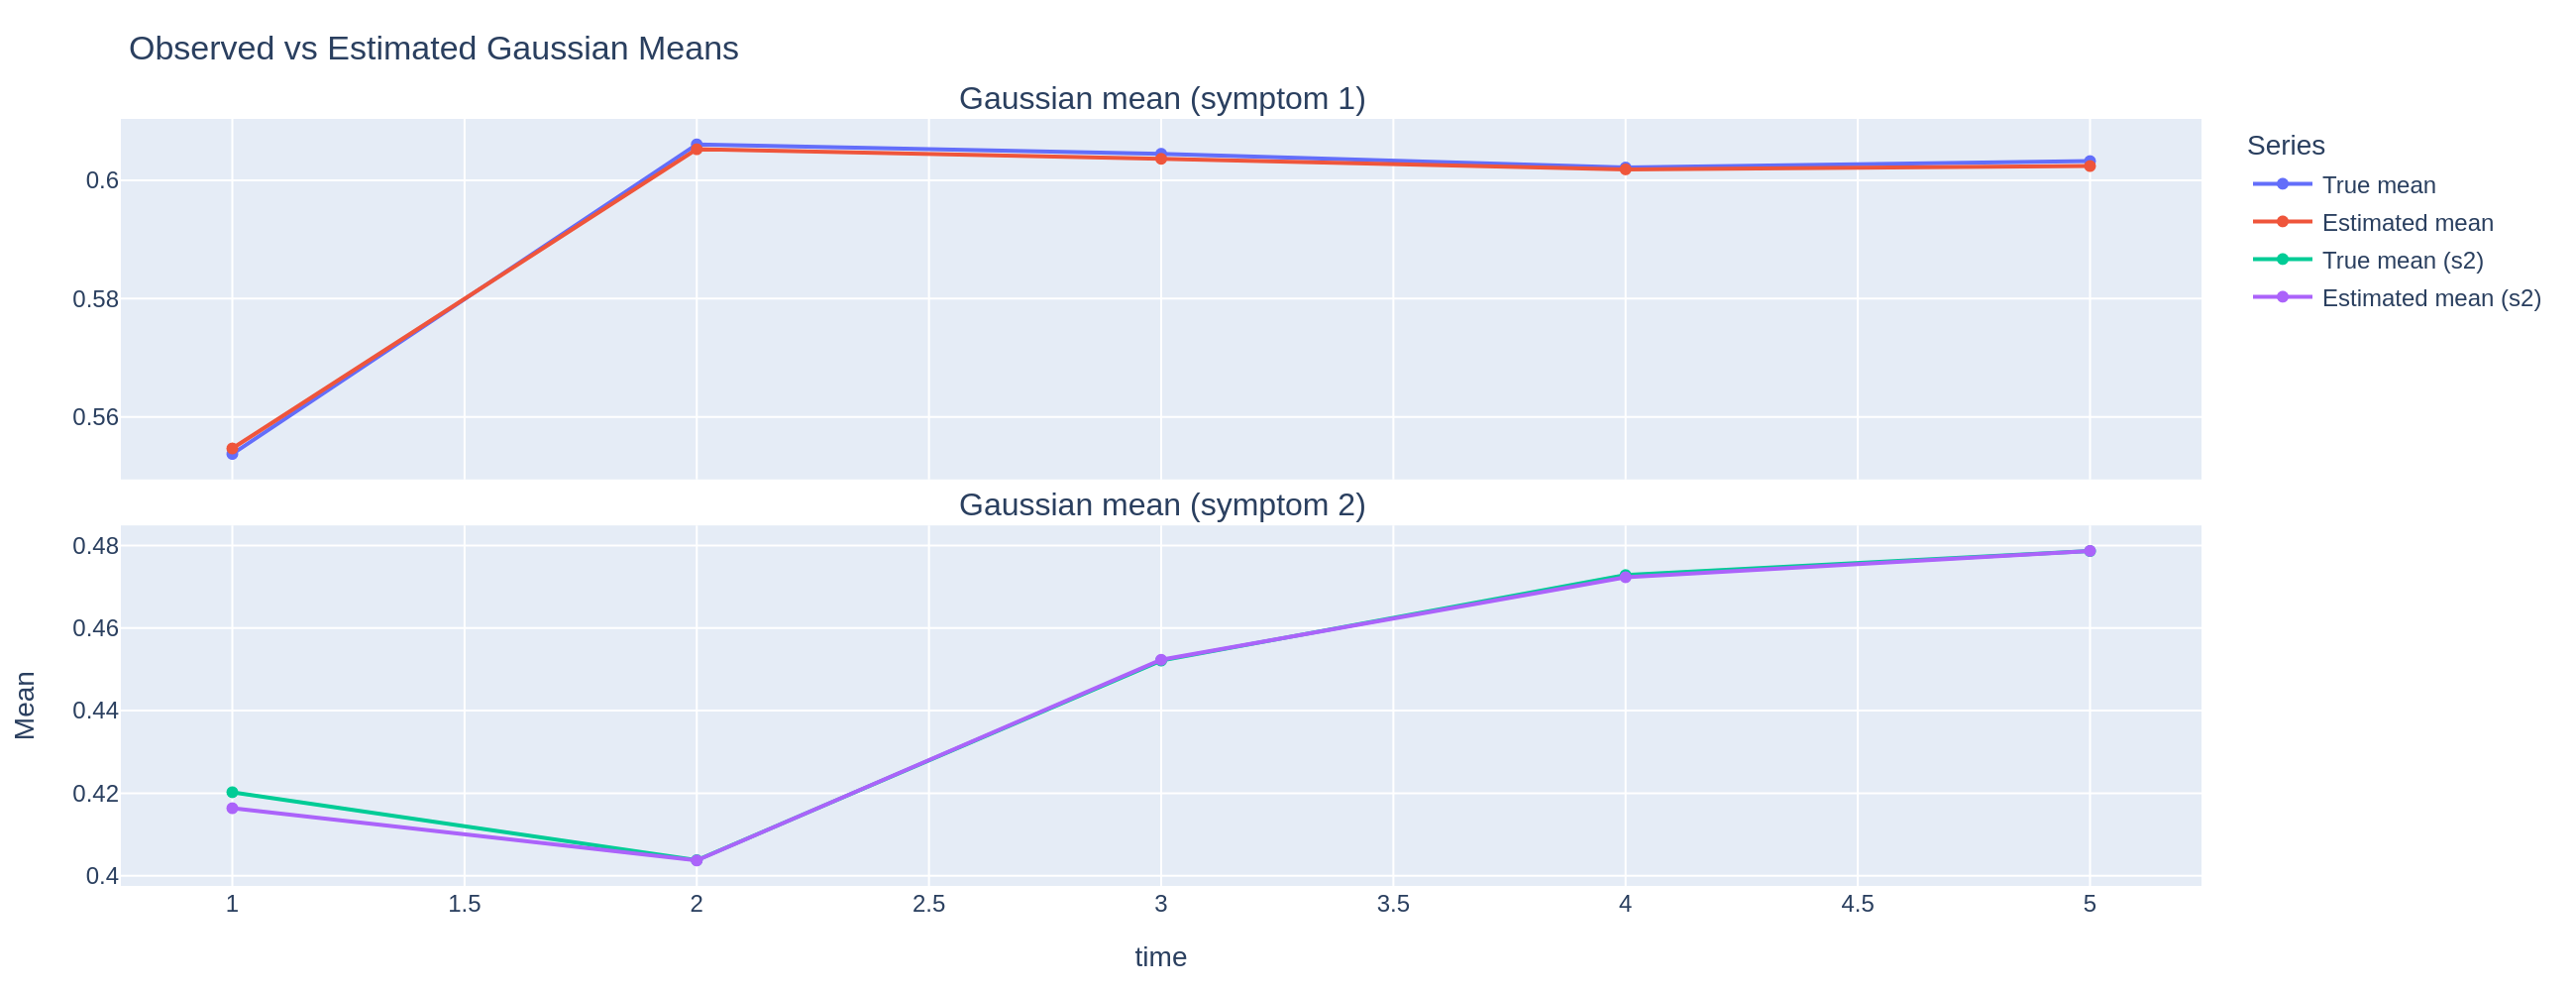

In [12]:
gaussian_predictions = LTA.compare_estimation_2_data(
    est_output;
    simulation_seed = 1,
    T = 5,
    type = "best_fitted",
    observation_type = "gaussian",
)
show_png(to_pngbytes(gaussian_predictions; width = 1300)) 

We see find that our converged solution also matches up with the data well.